<a href="https://colab.research.google.com/github/Storm00212/Introduction-to-machine-learning-models/blob/main/Violence_detection_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
#1. System & File Handling
import os
import zipfile
import random
import glob
import shutil
#2. Video Processing & Image Utilities
import cv2                # OpenCV for reading videos & extracting frames
import numpy as np
from PIL import Image     # Optional for additional image manipulation
#3. Data Analysis & Visualization
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Enable inline plotting for Colab
%matplotlib inline
#4. Machine Learning / Deep Learning
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#5. Deep Learning Layers and Tools
from tensorflow.keras.layers import (
    Conv2D, MaxPooling2D, Flatten, Dense, Dropout, LSTM, TimeDistributed, BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
# 6. Model Evaluation Tools
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import itertools
#  7. Progress & Logging
from tqdm import tqdm     # for progress bars
import warnings
warnings.filterwarnings('ignore')


In [14]:
# Step 1: Dataset Loading and Directory Setup

# Import required libraries
import os
import shutil
import zipfile

# Clone the public GitHub repository that contains the violence detection dataset
!git clone https://github.com/airtlab/A-Dataset-for-Automatic-Violence-Detection-in-Videos.git

# Change the current working directory to the cloned repository
os.chdir("A-Dataset-for-Automatic-Violence-Detection-in-Videos")

# Display the folder structure to confirm that the dataset is available
for root, dirs, files in os.walk(".", topdown=True):
    level = root.replace(os.getcwd(), '').count(os.sep)
    indent = ' ' * 4 * level
    print(f"{indent}{os.path.basename(root)}/")
    subindent = ' ' * 4 * (level + 1)
    for f in files:
        print(f"{subindent}{f}")

# Create organized folders for training and testing data
base_dir = "/content/violence_dataset"
train_dir = os.path.join(base_dir, "train")
test_dir = os.path.join(base_dir, "test")

# Define subdirectories for each class (violent and non-violent)
train_violent_dir = os.path.join(train_dir, "violent")
train_nonviolent_dir = os.path.join(train_dir, "non_violent")
test_violent_dir = os.path.join(test_dir, "violent")
test_nonviolent_dir = os.path.join(test_dir, "non_violent")

# Create all directories if they do not already exist
os.makedirs(train_violent_dir, exist_ok=True)
os.makedirs(train_nonviolent_dir, exist_ok=True)
os.makedirs(test_violent_dir, exist_ok=True)
os.makedirs(test_nonviolent_dir, exist_ok=True)

print("Directory structure ready.")


Cloning into 'A-Dataset-for-Automatic-Violence-Detection-in-Videos'...
remote: Enumerating objects: 376, done.
remote: Counting objects: 100% (12/12), done.
remote: Compressing objects: 100% (9/9), done.
remote: Total 376 (delta 3), reused 11 (delta 3), pack-reused 364 (from 1)
Receiving objects: 100% (376/376), 1.02 GiB | 41.50 MiB/s, done.
Resolving deltas: 100% (3/3), done.
Updating files: 100% (355/355), done.
./
    readme.md
    .gitignore
    violence-detection-dataset/
        action-class-occurrences.csv
        violent-action-classes.csv
        nonviolent-action-classes.csv
        non-violent/
            cam2/
                37.mp4
                40.mp4
                36.mp4
                38.mp4
                25.mp4
                1.mp4
                27.mp4
                7.mp4
                46.mp4
                14.mp4
                5.mp4
                45.mp4
                9.mp4
                13.mp4
                48.mp4
                50.mp4
     

In [15]:
# mergin cam 1 and cam 2 videos
def get_all_videos(folder_path):
  videos=[]
  cam1_path=os.path.join(folder_path, "cam1")
  cam2_path=os.path.join(folder_path, "cam2")

  if os.path.exists(cam1_path) and os.path.exists(cam2_path):
    videos += [os.path.join(cam1_path, f) for f in os.listdir(cam1_path) if f.endswith(".mp4")] + [os.path.join(cam2_path, f) for f in os.listdir(cam2_path) if f.endswith(".mp4")]

  return videos

# Collect violent and non-violent videos
dataset_path = os.path.join(os.getcwd(), "violence-detection-dataset")
violent_videos = get_all_videos(os.path.join(dataset_path, "violent"))
nonviolent_videos = get_all_videos(os.path.join(dataset_path, "non-violent"))

print(f"Total violent videos: {len(violent_videos)}")
print(f"Total non-violent videos: {len(nonviolent_videos)}")

random.shuffle(violent_videos)
random.shuffle(nonviolent_videos)

def split_data(videos, split_ratio=0.8):
  split_index =  int(len(videos) * split_ratio)
  return videos[:split_index], videos[split_index:]


violent_train, violent_test = split_data(violent_videos)
nonviolent_train, nonviolent_test = split_data(nonviolent_videos)
# Function to copy videos into the right directory
def copy_files(file_list, target_folder):
  for f in file_list:
    shutil.copy(f, target_folder)
# Copy all videos to the train/test folders
copy_files(violent_train, train_violent_dir)
copy_files(violent_test, test_violent_dir)
copy_files(nonviolent_train, train_nonviolent_dir)
copy_files(nonviolent_test, test_nonviolent_dir)

print("Dataset organized successfully into training and testing folders.")
print(f"Training set: {len(violent_train) + len(nonviolent_train)} videos")
print(f"Testing set: {len(violent_test) + len(nonviolent_test)} videos")

Total violent videos: 230
Total non-violent videos: 120
Dataset organized successfully into training and testing folders.
Training set: 280 videos
Testing set: 70 videos


In [17]:
# Frame extraction and processing
def extract_frames(video_path, num_frames=20, resize=(64, 64)):
  frames= []
  try:
    cap= cv2.VideoCapture(video_path)
    total_frames= int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    # Determining intervals to extract evenly spaced frames.
    frame_interval= max(total_frames // num_frames, 1)
    for i in range(0, total_frames, frame_interval):
      ret, frame= cap.read()
      if not ret:
        break
      frame= cv2.resize(frame, resize)# Reesize each frame for uniformity.
      # Normalise pixel values between 0 and 1
      frame= frame/255.0
      frames.append(frame)
      # Stop once required frames are collected.
      if len(frames) == num_frames:
        break
    cap.release()

    return np.array(frames)

  except Exception as e:
    print(f"Error extracting frames from {video_path}: {e}")
    return None

data=[]
labels=[]

violent_path = "/content/violence_dataset/train/violent"
nonviolent_path = "/content/violence_dataset/train/non_violent"

# Extract frames from violent videos
for folder in ["",]:
    folder_path = violent_path
    for video in tqdm(os.listdir(folder_path), desc=f"Processing violent"):
        video_path = os.path.join(folder_path, video)
        frames = extract_frames(video_path)
        if frames is not None:
            data.append(frames)
            labels.append(1)  # Label 1 for violent

# Extract frames from non-violent videos
for folder in ["",]:
    folder_path = nonviolent_path
    for video in tqdm(os.listdir(folder_path), desc=f"Processing non-violent"):
        video_path = os.path.join(folder_path, video)
        frames = extract_frames(video_path)
        if frames is not None:
            data.append(frames)
            labels.append(0)  # Label 0 for non-violent


# Convert data and labels to NumPy arrays
data = np.array(data)
labels = np.array(labels)

print("Frame extraction completed.")
print(f"Data shape: {data.shape}, Labels shape: {labels.shape}")

Processing non-violent: 100%|██████████| 60/60 [00:17<00:00,  3.53it/s]


Frame extraction completed.
Data shape: (175, 20, 64, 64, 3), Labels shape: (175,)


X_train shape: (105, 20, 64, 64, 3), y_train shape: (105,)
X_val shape: (35, 20, 64, 64, 3), y_val shape: (35,)
X_test shape: (35, 20, 64, 64, 3), y_test shape: (35,)
Final training set shape: (210, 20, 64, 64, 3)


Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_4              │ (None, 20, 2, 2, 2048) │    23,587,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 20, 2, 2, 64)   │     1,179,712 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_6              │ (None, 20, 2, 2, 64)   │           256 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_7              │ (None, 20, 1, 1, 64)   │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_lstm2d_4 (ConvLSTM2D)      │ (None, 1, 1, 64)       │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 1, 1, 64)       │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1, 1, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,071,553 (95.64 MB)

 Trainable params: 1,483,585 (5.66 MB)

 Non-trainable params: 23,587,968 (89.98 MB)

Epoch 1/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 270s 5s/step - accuracy: 0.5090 - loss: 0.7363 - val_accuracy: 0.6571 - val_loss: 0.7054 - learning_rate: 1.0000e-04
Epoch 2/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4692 - loss: 0.7504 - val_accuracy: 0.6571 - val_loss: 0.6981 - learning_rate: 1.0000e-04
Epoch 3/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 80s 3s/step - accuracy: 0.5503 - loss: 0.7040 - val_accuracy: 0.6857 - val_loss: 0.6975 - learning_rate: 1.0000e-04
Epoch 4/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6353 - loss: 0.6696 - val_accuracy: 0.6571 - val_loss: 0.6949 - learning_rate: 1.0000e-04
Epoch 5/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.6866 - loss: 0.6402 - val_accuracy: 0.8000 - val_loss: 0.6958 - learning_rate: 1.0000e-04
Epoch 6/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 83s 3s/step - accuracy: 0.6836 - loss: 0.6392 - val_accuracy: 0.6571 - val_loss: 0.6907 - learning_rate: 1.0000e-04
Epoch 7/60
27/27 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.6031 - loss

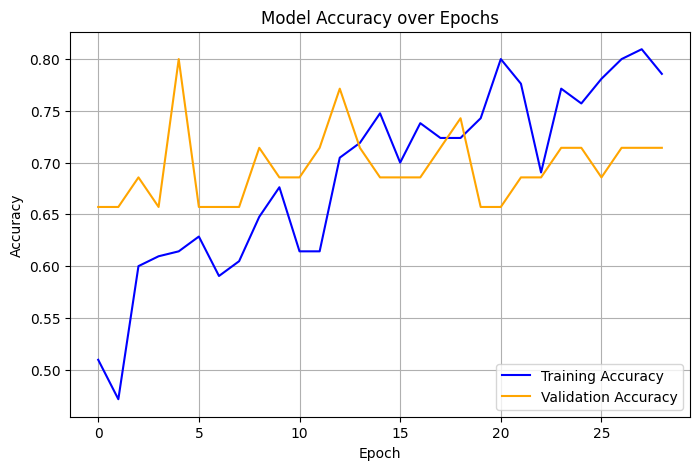

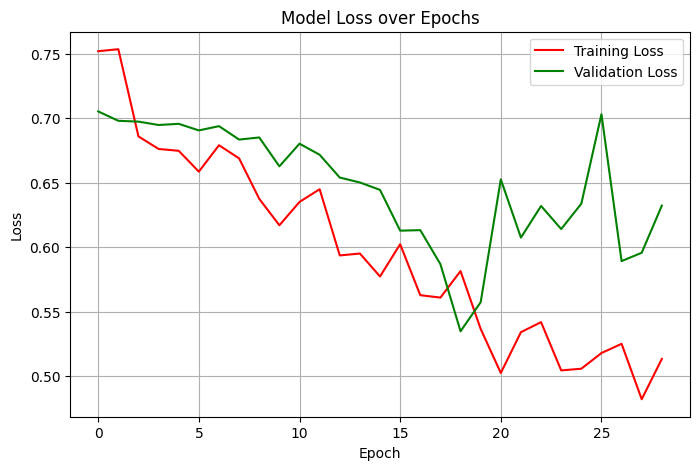

In [26]:
# SECTION: Imports
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Assuming 'data' and 'labels' are already loaded as NumPy arrays
# data shape: (num_videos, frames, 64, 64, 3)
# labels shape: (num_videos,)

# SECTION: Data Splitting
X_train_val, X_test, y_train_val, y_test = train_test_split(
    data, labels, test_size=0.2, random_state=42, stratify=labels
)

X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val
)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

# SECTION: Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_video(video):
    return np.array([datagen.random_transform(frame) for frame in video])

X_train_aug = np.array([augment_video(v) for v in X_train])
y_train_aug = np.array(y_train)

# Combine original and augmented data
X_train_final = np.concatenate((X_train, X_train_aug))
y_train_final = np.concatenate((y_train, y_train_aug))

print(f"Final training set shape: {X_train_final.shape}")

# SECTION: Model Definition (Fixed)
def build_violence_detection_model(input_shape):
    # Base CNN (no global pooling)
    base_cnn = ResNet50(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
    base_cnn.trainable = False  # freeze layers

    # Wrap CNN in TimeDistributed without pooling to preserve spatial maps
    model = models.Sequential([
        layers.TimeDistributed(base_cnn, input_shape=input_shape),
        layers.TimeDistributed(layers.Conv2D(64, (3, 3), activation='relu', padding='same')),
        layers.TimeDistributed(layers.BatchNormalization()),
        layers.TimeDistributed(layers.MaxPooling2D((2, 2))),
        layers.ConvLSTM2D(64, (3, 3), activation='relu', return_sequences=False, padding='same',
                          kernel_regularizer=regularizers.l2(1e-4)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Flatten(),
        layers.Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    return model

model = build_violence_detection_model((20, 64, 64, 3))
model.summary()

# SECTION: Training Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', patience=5, factor=0.3, min_lr=1e-6)

# SECTION: Model Training
history = model.fit(
    X_train_final, y_train_final,
    validation_data=(X_val, y_val),
    epochs=60,
    batch_size=8,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# SECTION: Evaluation
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Test Accuracy: {test_acc*100:.2f}%")

model.save("violence_detection_fixed.keras")

# SECTION: Plot Accuracy and Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Model Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss', color='red')
plt.plot(history.history['val_loss'], label='Validation Loss', color='green')
plt.title('Model Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
#we should have higher accuracy by now
